# Estimating elasticities with Random Forest

This is a project that concerns the application of machine learning (ML) in causal inference. Here, in particular, we are going to apply one of the most pervasively used ML methods, Random Forest, to estimate price elasticity for Fullfilment BY Amazon (FBA) retailer. Let us start by loading necessary packages first.  

In [1]:
import pandas as pd, numpy as np
from datetime import datetime, date
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

The dataset in use here is a publicly available data which is available [here](https://www.kaggle.com/vijayuv/onlineretail). Let's have a snippet at the dataset:

In [2]:
df = pd.read_csv('E:\Jupyter_files\OnlineRetail.csv')

df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
63472,541571,22668,PINK BABY BUNTING,5,1/19/2011 12:38,2.95,12841.0,United Kingdom
276582,561064,82484,WOOD BLACK BOARD ANT WHITE FINISH,4,7/24/2011 14:16,7.95,18109.0,United Kingdom
147081,549053,22281,EASTER TREE YELLOW BIRDS,2,4/6/2011 10:20,5.95,13863.0,United Kingdom
23783,538248,21787,RAIN PONCHO RETROSPOT,2,12/10/2010 12:14,0.85,18116.0,United Kingdom
362877,568527,16161P,WRAP ENGLISH ROSE,25,9/27/2011 13:21,0.42,13178.0,United Kingdom
514938,579751,22776,SWEETHEART 3 TIER CAKE STAND,1,11/30/2011 14:46,19.96,NaN,United Kingdom
263988,560049,22853,CAT BOWL VINTAGE CREAM,6,7/14/2011 15:03,3.25,14857.0,United Kingdom
176651,C552012,23183,MOTHER'S KITCHEN SPOON REST,-6,5/5/2011 17:29,3.75,13552.0,United Kingdom
269960,560535,82486,WOOD S/3 CABINET ANT WHITE FINISH,2,7/19/2011 12:13,8.95,13167.0,United Kingdom
167205,550986,22321,BIRD DECORATION RED RETROSPOT,1,4/21/2011 18:06,1.63,NaN,United Kingdom


As we are going to estimate elasticity, quantity and price are thwo variables that we are mostly concerned with. Let's look at some descriptive statistics of these two variables. 

In [3]:
pd.DataFrame([df.Quantity.describe(),df.UnitPrice.describe()])

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0


It looks like that we need to deal with outliers on both side. First of all, the smallest values for both the variables are negative, which doesn't fall within the feasible range. May be it's the entries for returns from customers. Let's just get rid of such negative entries first from the datafarme.

In [4]:
df = df[
    (df.Quantity > 0) &
    (df.UnitPrice > 0)
]
pd.DataFrame([df.Quantity.describe(),df.UnitPrice.describe()])

,count,mean,std,min,25%,50%,75%,max
Quantity,530104.0,10.542037,155.524124,1.000,1.00,3.00,10.00,80995.00
UnitPrice,530104.0,3.907625,35.915681,0.001,1.25,2.08,4.13,13541.33


Description column of the dataset is a great way to understand the entries. Fortunately, StockCode gives us some non-numerical values which are suspect for not being sells entries. Let's try and find out those entries first. 

In [5]:
df[~df["StockCode"].str[0].str.isnumeric()].StockCode.unique()

array(['POST', 'C2', 'DOT', 'M', 'BANK CHARGES', 'AMAZONFEE', 'DCGS0076',
       'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm', 'gift_0001_50',
       'gift_0001_30', 'gift_0001_20', 'DCGS0069', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'S', 'PADS', 'DCGS0004', 'B'],
      dtype=object)

Our next step is to carefully investigate all such entries and determine which ones are not sales record from the description column. Then we get rid of those rows from the dataframe. 

In [6]:
df = df[~df.StockCode.isin(['POST', 'DOT', 'M', 'AMAZONFEE', 'BANK CHARGES', 'C2', 'B', 'S'])]

Now, we need to take care of a couple of things now. First, let's try to deal with the outliers on the upper side. 

In [7]:
df.nlargest(5, columns='Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.21,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.72,13135.0,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2/22/2011 10:43,0.82,18087.0,United Kingdom


In [8]:
df.nlargest(5, columns='UnitPrice')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,6/10/2011 15:28,649.5,15098.0,United Kingdom
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,6/10/2011 15:33,649.5,15098.0,United Kingdom
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,12/2/2010 18:06,295.0,13145.0,United Kingdom
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,12/16/2010 8:41,295.0,16607.0,United Kingdom
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,1/10/2011 14:57,295.0,17406.0,United Kingdom


In [9]:
df = df[~df.InvoiceNo.isin(["581483","541431"])]
pd.DataFrame([df.Quantity.describe(),df.UnitPrice.describe()])

,count,mean,std,min,25%,50%,75%,max
Quantity,527791.0,10.272867,37.732211,1.000,1.00,3.00,11.00,4800.0
UnitPrice,527791.0,3.266470,4.380817,0.001,1.25,2.08,4.13,649.5


Now, merely looking into the UnitPrice in the table above, the jump from 75th percentile to max generates suspicion. Let us look at this closely.

In [10]:
np.sort(df.groupby("StockCode").agg({'UnitPrice': ['min', 'max']})["UnitPrice"]["max"]-
df.groupby("StockCode").agg({'UnitPrice': ['min', 'max']})["UnitPrice"]["min"])[-10:]

array([ 46.78,  49.21,  67.31,  73.29,  80.01,  89.96, 110.  , 245.  ,
       245.  , 647.5 ])

So, we see that there lies quite a large gap between the minimum and maximum price for a particualr stock code. Considering this data is an eight month observation, this seems like wrong entry or something like that. We clean those data from our dataframe. We are going to use the logic that the price should not be less than one-third of the median price and should not be greater than three times of median. 

In [11]:
df = (
    df
    .assign(
        dNormalPrice=lambda d: d.UnitPrice 
            / d.groupby('StockCode').UnitPrice.transform('median') 
    )
    .pipe(
        lambda d: d[
            (d['dNormalPrice'] > 1./3) &
            (d['dNormalPrice'] < 3.)
        ]
    )
    .drop(columns=['dNormalPrice'])
)

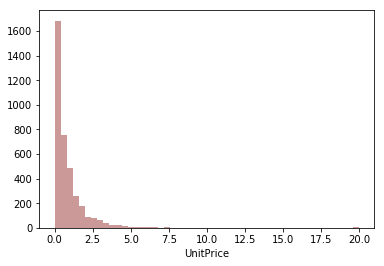

In [12]:
sns.distplot(df.groupby('StockCode').UnitPrice.std().dropna().clip(0, 20), kde=False, color = "maroon")

Next, we understand that this retail seller has a wide range of products and elasticity for each of them might be different. Therefore, we group the data by stockcode, date and country. We save data in .parquet format.

In [13]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate)
df['Date'] = pd.to_datetime(df.InvoiceDate.dt.date)
df['revenue'] = df.Quantity * df.UnitPrice

df = df.groupby(['Date', 'StockCode', 'Country'], as_index=False).agg({
    'Description': 'first',
    'Quantity': 'sum', 
    'revenue': 'sum'
})
df['Description'] = df.groupby('StockCode').Description.transform('first')

df['UnitPrice'] = df['revenue'] / df['Quantity'] # implicit quantity-weighted avg of prices

In [14]:
df.to_parquet('ecom_sample_clean.parquet')

## Double Machine Learning with Random Forest

In [2]:
df = pd.read_parquet('ecom_sample_clean.parquet')
df.set_index(['Date', 'StockCode', 'Country']).sample(10)

,,,Description,Quantity,revenue,UnitPrice
Date,StockCode,Country,,,,
2011-02-27,22800,United Kingdom,ANTIQUE TALL SWIRLGLASS TRINKET POT,4,15.00,3.750
2011-12-01,22233,United Kingdom,JIGSAW RABBIT AND BIRDHOUSE,24,14.16,0.590
2010-12-15,22385,United Kingdom,JUMBO BAG SPACEBOY DESIGN,2,3.90,1.950
2011-10-05,23236,Germany,DOILEY STORAGE TIN,12,34.68,2.890
2011-06-22,23165,United Kingdom,LARGE CERAMIC TOP STORAGE JAR,16,26.40,1.650
2011-06-20,35923,United Kingdom,CANDY HEART HANGING DECORATION,15,5.85,0.390
2011-04-10,20728,United Kingdom,LUNCH BAG CARS BLUE,6,9.90,1.650
2011-02-28,22326,Switzerland,ROUND SNACK BOXES SET OF4 WOODLAND,12,35.40,2.950
2011-11-08,35953,United Kingdom,FOLKART STAR CHRISTMAS DECORATIONS,80,38.24,0.478


First, we do a little more data preparation. We are going to exlcude the products with no variation in price. 

In [3]:
df_mdl = df[
    (df.groupby('StockCode').UnitPrice.transform('std') > 0)
]
del df

In [4]:
df_mdl = df_mdl.assign(                     #Then we create two columns for log of price and quantity
    LnP = np.log(df_mdl['UnitPrice']),
    LnQ = np.log(df_mdl['Quantity']),
)

df_mdl = df_mdl.sample(1000)                #We reduce the sample size just to run our codes faster

Next we do an item level de-meaning ($dlogP$ and $dlogQ$) to take care of item level fixed effect in the model. The feautre for the random forests are added to the dataset as follows:

- Month, day of month and day of week of the invoice date.

- Age of the stock calculated from the oldest date of the stock code to the selling day. This is for acknowledging trend. 

- Meadian price per Stock code. 

In [6]:
df_mdl['dLnP'] = np.log(df_mdl.UnitPrice) - np.log(df_mdl.groupby('StockCode').UnitPrice.transform('mean'))
df_mdl['dLnQ'] = np.log(df_mdl.Quantity) - np.log(df_mdl.groupby('StockCode').Quantity.transform('mean')) 

df_mdl = df_mdl.assign(
    month = lambda d: d.Date.dt.month,
    DoM =   lambda d: d.Date.dt.day,
    DoW =   lambda d: d.Date.dt.weekday,
    stock_age_days = lambda d: 
        (d.Date - d.groupby('StockCode').Date.transform('min')).dt.days,
    sku_avg_p = lambda d: 
        d.groupby('StockCode').UnitPrice.transform('median')
)

With feature generator, we input all the features created above as numerical feature. We also consider categorical features such as date, description and country. 

In [7]:
feature_generator_full = ColumnTransformer(
    [
        # do NOT include to reduce overfit (price is sku-level-demeaned anyway): 
        # ('StockCode', OneHotEncoder(), ['StockCode']), 
        ('Date', OneHotEncoder(categories='auto'), ['Date']),
        ('Description', CountVectorizer(min_df=0.0025, ngram_range=(1, 3)), 'Description'),
        ('Country', OneHotEncoder(categories='auto'), ['Country']),
        ('numeric_feats', StandardScaler(), ['month', 'DoM', 'DoW', 'stock_age_days', 'sku_avg_p']),
    ], remainder='drop'
)

We model both quantity and price with the features above through random forest regressors. We then fit the models and save them through joblibs. We use joblibs just to save time. 

In [8]:
model_y = Pipeline([
    ('feat_proc', feature_generator_full),
    ('model_y', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=0)) 
    # n_samples_leaf/n_estimators is set to reduce model (file) size and runtime
    # larger models yield prettier plots.
])
model_t = Pipeline([
    ('feat_proc', feature_generator_full),
    ('model_t', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=0))
])

In [11]:
import joblib

try: # load existing models, if possible
    model_y = joblib.load('models/step1_model_y.joblib')
    model_t = joblib.load('models/step1_model_t.joblib')
except:
    print('No pre-existing models found, fitting aux models for y and t')
    model_y.fit(df_mdl, df_mdl.dLnQ)
    model_t.fit(df_mdl, df_mdl.dLnP)
    
    joblib.dump(model_y, 'models/step1_model_y.joblib', compress=True)
    joblib.dump(model_t, 'models/step1_model_t.joblib', compress=True)

No pre-existing models found, fitting aux models for y and t


We then predict the model and create the columns for saving the residuals for both quantity and price. Fianlly, we calculate the elasticity by $\hat{\epsilon} = (\tilde{P} P)^-1 \tilde{P}\tilde{Q} $. One thing to note here is that the second $P$ is not residualized.  

In [12]:
q_hat = model_y.predict(df_mdl)
p_hat = model_t.predict(df_mdl)

In [13]:
df_mdl = df_mdl.assign(
    dLnP_res = df_mdl['dLnP'] - p_hat,
    dLnQ_res = df_mdl['dLnQ'] - q_hat,
)

In [14]:
elast = (
        df_mdl['dLnP_res'].dot(df_mdl['dLnQ_res'])
        /
        df_mdl['dLnP_res'].dot(df_mdl['dLnP'])
        # the last part here deviates from standard OLS solution
    )

In [15]:
elast

-1.3509633828176946

A more efficient estimator is when we split the data in two halves and use one half for residualizing process (auxiliary model) and other half for the final (inferential) model. Ideally what we would like to do is to split the sample in two halves for several times and estimate elasticities. Then we take mean of all the elasticities estimated and cosider that as our final estimate.   